# BNNs

In [1]:
from bayesian_models import Pbnn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from doepy import build
import pickle
from scipy.stats import norm, uniform, lognorm
from scipy.stats import qmc    #for sobol seq. (LHS is also available in this QuasiMC library)

In [2]:
from LStates.g11D_electric import example_electric

function = example_electric

def convert_lognormal(mean_ln, std_ln):
    gaussian_param = np.zeros(2)

    SigmaLogNormal = np.sqrt( np.log(1+(std_ln/mean_ln)**2))
    MeanLogNormal = np.log( mean_ln ) - SigmaLogNormal**2/2

    gaussian_param[0] = MeanLogNormal
    gaussian_param[1] = SigmaLogNormal

    return gaussian_param

In [3]:
# X1 = L (m) mean=4.2    cov=0.10   lognormal/R>0
x1_mean = 4.20
x1_std = x1_mean * 0.10
normal_std_1 = np.sqrt(np.log(1 + (x1_std/x1_mean)**2))
normal_mean_1 = np.log(x1_mean) - normal_std_1**2 / 2

# X2 = h (m) mean=0.02    cov=0.10 lognormal /R>0
x2_mean = 0.02
x2_std = x2_mean * 0.1
normal_std_2 = np.sqrt(np.log(1 + (x2_std/x2_mean)**2))
normal_mean_2 = np.log(x2_mean) - normal_std_2**2 / 2

# X3 = d (m) mean=0.001  cov=0.05 lognormal /R>0
x3_mean = 0.001
x3_std = x3_mean * 0.05
normal_std_3 = np.sqrt(np.log(1 + (x3_std/x3_mean)**2))
normal_mean_3 = np.log(x3_mean) - normal_std_3**2 / 2

# X4 = ZL () mean=1000    cov=0.20 lognormal /R>0
x4_mean = 1000
x4_std = x4_mean * 0.2
normal_std_4 = np.sqrt(np.log(1 + (x4_std/x4_mean)**2))
normal_mean_4 = np.log(x4_mean) - normal_std_4**2 / 2

# X5 = Z0 () mean=50   cov=0.05 lognormal /R>0
x5_mean = 50
x5_std = x5_mean * 0.05
normal_std_5 = np.sqrt(np.log(1 + (x5_std/x5_mean)**2))
normal_mean_5 = np.log(x5_mean) - normal_std_5**2 / 2

# X6 = ae (V/m) mean=1  cov=0.20 lognormal /R>0
x6_mean = 1
x6_std = x6_mean * 0.2
normal_std_6 = np.sqrt(np.log(1 + (x6_std/x6_mean)**2))
normal_mean_6 = np.log(x6_mean) - normal_std_6**2 / 2

# X7 = theta_e (rad) mean=pi/4    cov=0.577 uniform / [0,pi/2]
x7_min = 0
x7_max = np.pi / 2

# X8 = theta_p (rad) mean=pi/4    cov=0.577 uniform / [0,pi/2]
x8_min = 0
x8_max = np.pi / 2

# X9 = phi_p (rad) mean=pi   cov=0.577 uniform / [0,pi*2]
x9_min = 0
x9_max = np.pi*2

# X10 = f (MHz) mean=30    cov=0.096 uniform / [25 ,35]
x10_min = 25e6
x10_max = 35e6

# X11 = alpha (-) mean=0.0010  cov=0.289 uniform / [0.0005 , 0.0015]
x11_min = 0.0005
x11_max =  0.0015

In [4]:
dim = 11
n_mcs = int(1e6)
X = np.zeros((n_mcs,dim))
L = X[:,0] = np.random.lognormal(mean=normal_mean_1, sigma=normal_std_1, size=n_mcs)   #L (m)
h = X[:,1] = np.random.lognormal(mean=normal_mean_2, sigma=normal_std_2, size=n_mcs)   #h (m)
d = X[:,2] = np.random.lognormal(mean=normal_mean_3, sigma=normal_std_3, size=n_mcs)   #d (m)
ZL = X[:,3] = np.random.lognormal(mean=normal_mean_4, sigma=normal_std_4, size=n_mcs)   #ZL ()
Z0 = X[:,4] = np.random.lognormal(mean=normal_mean_5, sigma=normal_std_5, size=n_mcs)   #Z0 ()
ae = X[:,5] = np.random.lognormal(mean=normal_mean_6, sigma=normal_std_6, size=n_mcs)   #ae (V/m)
theta_e = X[:,6] = np.random.uniform(low=x7_min, high=x7_max, size=n_mcs)        #theta_e (rad)
theta_p = X[:,7] = np.random.uniform(low=x8_min, high=x8_max, size=n_mcs)        #theta_p (rad)
phi_p =  X[:,8] = np.random.uniform(low=x9_min, high=x9_max, size=n_mcs)        #phi_p (rad)
f = X[:,9] = np.random.uniform(low=x10_min, high=x10_max, size=n_mcs)      #f (MHz)
alpha = X[:,10] = np.random.uniform(low=x11_min, high=x11_max, size=n_mcs)     #alpha (-)

y_test = function(X)
Pf_ref = np.sum( y_test < 0 ) / n_mcs
B_ref= - norm.ppf( Pf_ref )
Pf_ref, B_ref

(0.000229, 3.5041891047658114)

In [5]:
exp = {'x1': [x1_mean, x1_std, 'lognormal'],
 'x2': [x2_mean, x2_std, 'lognormal'],
 'x3': [x3_mean, x3_std, 'lognormal'],
 'x4': [x4_mean, x4_std, 'lognormal'],
 'x5': [x5_mean, x5_std, 'lognormal'],
 'x6': [x6_mean, x6_std, 'lognormal'],
 'x7': [x7_min, x7_max, 'uniform'],
 'x8': [x8_min, x8_max, 'uniform'],
 'x9': [x9_min, x9_max, 'uniform'],
 'x10': [x10_min, x10_max, 'uniform'],
 'x11': [x11_min, x11_max, 'uniform']}

In [32]:
passive_samples = 100

#PASSIVE TRAINING---------------------------------------------------
X = np.zeros((passive_samples, dim))
X_norm = np.zeros((passive_samples, dim))

exp_norm = {}
for var_name in range(dim):
    exp_norm['x'+ str(var_name+1)] = [0.000001, 0.999999]    #initial design domain for each variable (normal, uniform)
#Latin hypercube sampling
Xdoe = build.space_filling_lhs(exp_norm , num_samples = passive_samples)

for margin in range (0, dim):
    var = 'x' + str (margin + 1)

    X_norm[:, margin] = Xdoe[var]

    if exp[var][2] == 'normal':
        loc_ = exp[var][0]
        scale_ = exp[var][1]
        X[:, margin] = norm.ppf(Xdoe[var], loc=loc_, scale=scale_)

    elif exp[var][2] == 'uniform':
        loc_ = exp[var][0]
        scale_ = exp[var][1]
        X[:, margin] = uniform.ppf(Xdoe[var], loc=loc_, scale=scale_-loc_)

    elif exp[var][2] == 'lognormal':
        xlog_mean = exp[var][0]
        xlog_std = exp[var][1]
        gaussian_param = convert_lognormal(xlog_mean, xlog_std)
        X[:, margin] = lognorm.ppf(Xdoe[var], s=gaussian_param[1], scale=xlog_mean) 

Y = function(X)
y_max = np.max(y_test)
Y_norm = Y/y_max

In [33]:
output = 1
layers, archit = 2 , [20, 20] #change archit size if layers are increased

#-------------------------------------------creating bnn
#setting up the network architecture -----------------------------------
config = {"n_infeatures": dim,
        "n_outfeatures": output,
        "n_samples": len(X),
        "learn_all_params": False,  #to learn mean and sigma
        "fixed_param": 0.001} 

mybnn = Pbnn(config)
mybnn.build_bnn(layers, archit) #----------------------------------------------------------MODEL ARCHITECTURE

Training BNN With 100 samples
Epoch 1/5000
13/13 [==============================] - 1s 7ms/step - loss: 290909.6250
Epoch 2/5000
13/13 [==============================] - 0s 6ms/step - loss: 259153.3125
Epoch 3/5000
13/13 [==============================] - 0s 5ms/step - loss: 222859.2188
Epoch 4/5000
13/13 [==============================] - 0s 6ms/step - loss: 150797.0938
Epoch 5/5000
13/13 [==============================] - 0s 6ms/step - loss: 77470.1328
Epoch 6/5000
13/13 [==============================] - 0s 6ms/step - loss: 30779.0059
Epoch 7/5000
13/13 [==============================] - 0s 5ms/step - loss: 16422.7871
Epoch 8/5000
13/13 [==============================] - 0s 3ms/step - loss: 16464.1641
Epoch 9/5000
13/13 [==============================] - 0s 3ms/step - loss: 20861.5625
Epoch 10/5000
13/13 [==============================] - 0s 3ms/step - loss: 17368.2793
Epoch 11/5000
13/13 [==============================] - 0s 3ms/step - loss: 19507.4980
Epoch 12/5000
13/13 [========

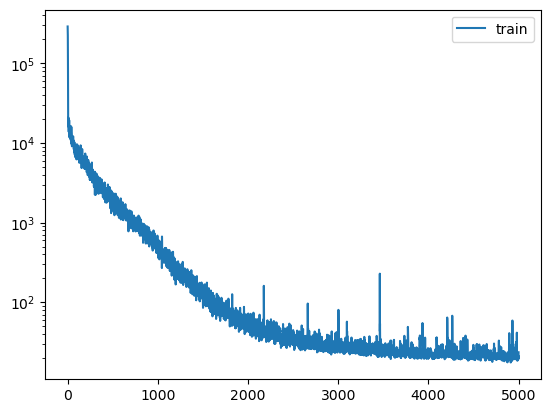

In [34]:
training_epochs = 5000
# batch_size = len(X)
batch_size = 8
# batch_size = [np.floor_divide(len(X), 10)][0] + 1  # half of the DoE
#-------------------------------------------training bnn
train_env = {"batch_size": batch_size,
            "learning_rate": 0.001,
            "epochs": training_epochs,
            "callback_patience": 500,
            "verbose": 1,
            "valid_split":0.0}
print('Training BNN With', len(X), 'samples' )
history = mybnn.train_bnn(X_norm, Y_norm, train_env)

train_loss = history.history['loss']
# val_loss = history.history['val_loss']
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(train_loss, label='train')
# ax.plot(val_loss, label='valid')
ax.set_yscale('log')
plt.legend()
plt.show()

In [35]:
Mean_muY_train, Stdv_muY_train, Mean_sigmaY_train, Stdv_sigmaY_train = mybnn.modeluq_bnn(X_norm, nsim = 100) 
np.max(Mean_muY_train.reshape(-1) - Y/y_max)

0.003534129261970498

In [39]:
np.min(Stdv_muY_train), np.max(Stdv_muY_train)

(0.0005609523533195448, 0.0072519167178502365)

In [36]:
n_mcs = int(1e6)
bnn_simulations = 100

#-------------------------------------------MC population
Xtest = np.zeros((int(n_mcs), dim))
MCinputs_norm= np.random.uniform(0.000001, 0.999999, size=(int(n_mcs), dim))

##Iso-probabilistic transformation-------------------------------------------
for margin in range (0, dim):
    var = 'x' + str (margin + 1)

    if exp[var][2] == 'normal':
        loc_ = exp[var][0]
        scale_ = exp[var][1]
        Xtest[:, margin] = norm.ppf(MCinputs_norm[:, margin], loc=loc_, scale=scale_)

    elif exp[var][2] == 'uniform':
        loc_ = exp[var][0]
        scale_ = exp[var][1]
        Xtest[:, margin] = uniform.ppf(MCinputs_norm[:, margin], loc=loc_, scale=scale_-loc_)

    elif exp[var][2] == 'lognormal':
        xlog_mean = exp[var][0]
        xlog_std = exp[var][1]
        gaussian_param = convert_lognormal(xlog_mean, xlog_std)
        Xtest[:, margin] = lognorm.ppf(MCinputs_norm[:, margin], s=gaussian_param[1], scale=xlog_mean) 

#-------------------------------------------model predictions over MC population
print('BNN predictions with MC population...')
Mean_muY_MC, Stdv_muY_MC, Mean_sigmaY_MC, Stdv_sigmaY_MC = mybnn.modeluq_bnn(MCinputs_norm, nsim = bnn_simulations)
y_mcs = function(Xtest)

PF = np.sum(Mean_muY_MC*y_max < 0) / n_mcs
B = - norm.ppf( PF )
PF_ref = np.sum(y_mcs < 0) / n_mcs

print('PF_ref =', PF_ref,'PF =', PF, 'and B =',"%.5f" % round(B, 3))

BNN predictions with MC population...
PF_ref = 0.000239 PF = 0.0 and B = inf


In [42]:
np.min(Stdv_muY_MC)

0.000362674221777682

Select MULTIPLE NEW training samples

In [ ]:
learning_points = 10
#-------------------------------------------Selecting MULTIPLE NEW training point
U_f = np.abs(Mean_muY_MC) / Stdv_muY_MC

U_min_args = np.argsort(U_f.reshape(-1))     #ordering arguments from min to max
X_new = Xtest[U_min_args[:learning_points]]  #choosing a given number of MC samples from the minimum U values
X = np.concatenate((X, X_new), axis=0)

Y_new = function(X_new)
Y = np.concatenate((Y, Y_new), axis=0)
len(Y)

In [ ]:
from pandas.plotting import scatter_matrix
import pandas as pd
df = pd.DataFrame(Xtest, columns=["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11"])
scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal="kde")

In [ ]:
dim = 11
output = 1
layers, archit = 2 , [128,128] #ange archit size if layers are increased
training_epochs = 15000
passive_samples = 1000
batch_size = 64

#PASSIVE TRAINING---------------------------------------------------
X = np.zeros((passive_samples, dim))

exp_norm = {}
for var_name in range(dim):
    exp_norm['x'+ str(var_name+1)] = [0.001, 0.999]    #initial design domain for each variable (normal, uniform)
#Latin hypercube sampling
Xdoe = build.space_filling_lhs(exp_norm , num_samples = passive_samples)

for margin in range (0, dim):
    var = 'x' + str (margin + 1)

    if exp[var][2] == 'normal':
        loc_ = exp[var][0]
        scale_ = exp[var][1]
        X[:, margin] = norm.ppf(Xdoe[var], loc=loc_, scale=scale_)

    elif exp[var][2] == 'uniform':
        loc_ = exp[var][0]
        scale_ = exp[var][1]
        X[:, margin] = uniform.ppf(Xdoe[var], loc=loc_, scale=scale_-loc_)

    elif exp[var][2] == 'lognormal':
        xlog_mean = exp[var][0]
        xlog_std = exp[var][1]
        gaussian_param = convert_lognormal(xlog_mean, xlog_std)
        X[:, margin] = lognorm.ppf(Xdoe[var], s=gaussian_param[1], scale=xlog_mean) 

Y = function(X)

#ACTIVE TRAIN LOOP ---------------------------------------------------
# for active in range(passive_samples, active_samples+passive_samples+1):

n_doe = len(X)
# batch_size = [np.floor_divide(n_doe, 2)][0] + 1  # half of the DoE

#-------------------------------------------creating bnn
#setting up the network architecture -----------------------------------
config = {"n_infeatures": dim,
        "n_outfeatures": output,
        "n_samples": n_doe,
        "learn_all_params": False,  #to learn mean and sigma
        "fixed_param": 0.001} 

ModelName = 'BNN_' + str(n_doe)
mybnn = Pbnn(config)

mybnn.build_bnn(layers, archit) #----------------------------------------------------------MODEL ARCHITECTURE
#-------------------------------------------training bnn
train_env = {"batch_size": batch_size,
            "learning_rate": 0.001,
            "epochs": training_epochs,
            "callback_patience": 4000,
            "verbose": 0}
print(' ')
print('Training BNN With', n_doe, 'samples' )
mybnn.train_bnn(X, Y, train_env)